In [14]:
# Loading Required Packages 
import cobra
from cobra.flux_analysis import flux_variability_analysis
import pandas as pd
import numpy as np
import itertools
import networkx as nx
import itertools
import xlsxwriter 

# Loading the Model 
model = cobra.io.read_sbml_model("ArabidopsisCoreModel1.xml")

# Changing the directionality of Fum_c to Mal_c to go the other way (day-time model) 
r = model.reactions.get_by_id('FumHA_c')
r.add_metabolites({model.metabolites.get_by_id('Fum_c'): +2})
r.add_metabolites({model.metabolites.get_by_id('H2O_c'): +2})
r.add_metabolites({model.metabolites.get_by_id('Mal_c'): -2})
print(r.reaction)
print(r.bounds)
print("Directionality changed. Dyson et al. 2016 \n")

# Creating a Malate "Storage" Reactions
r = cobra.Reaction('Mal_Store')
r.name = 'Mal_Store'
r.add_metabolites({model.metabolites.get_by_id('Mal_c'): -1})
model.add_reaction(r)
print(r.reaction)

# Creating a Fumarate "Storage" Reactions
r = cobra.Reaction('Fum_Store')
r.name = 'Fum_Store'
r.add_metabolites({model.metabolites.get_by_id('Fum_c'): -1})
model.add_reaction(r)
print(r.reaction)

# Creating a Starch "Storage" Reactions
r = cobra.Reaction('Starch_Store')
r.name = 'Starch_Store'
r.add_metabolites({model.metabolites.get_by_id('starch1_h'): -1})
model.add_reaction(r)
print(r.reaction)

cobra/core/reaction.py:394 UserWarning: malformed gene_reaction_rule '2*(ATCG00020 and ATCG00680 and ATCG00280 and ATCG00270 and ATCG00580 and ATCG00570 and ATCG00710 and ATCG00080 and ATCG00550 and ATCG00070 and ATCG00560 and ATCG00220 and ATCG00700 and (AT5G66570 or AT3G50820) and AT1G06680 and (AT4G21280 or AT4G05180) and AT1G79040 and AT1G44575 and ATCG00690 and AT3G21055 and AT2G30570 and AT2G06520 and AT1G67740 and ATCG00300)' for <Reaction PSII_h at 0x7f62cf94c7d0>
cobra/core/reaction.py:394 UserWarning: malformed gene_reaction_rule '2*(ATCG00540 and ATCG00720 and AT4G03280 and ATCG00730 and ATCG00600 and ATCG00590 and AT2G26500 and ATCG00210)' for <Reaction Cytb6f_h at 0x7f62cf94c790>
cobra/core/reaction.py:394 UserWarning: malformed gene_reaction_rule '8*(ATCG00490) and 8*(AT5G38430 or AT5G38420 or AT1G67090 or AT5G38410)' for <Reaction RBC_h at 0x7f62cf94c850>
cobra/core/reaction.py:394 UserWarning: malformed gene_reaction_rule '4*(AT3G26650 or AT1G12900) or (2*(AT3G26650 or 

Mal_c --> Fum_c + H2O_c
(0.0, 1000.0)
Directionality changed. Dyson et al. 2016 

Mal_c --> 
Fum_c --> 
starch1_h --> 


In [2]:

for r in model.reactions:
    if (r.subsystem == "light reactions"):
        print(r.id)
        print(r.reaction)


PSII_h
2.0 H2O_h + 4.0 H_h + 2.0 PQ_h + 4.0 hnu_h --> 4.0 H_l + O2_h + 2.0 PQH2_h
Cytb6f_h
2.0 H_h + 2.0 PCox_h + PQH2_h --> 4.0 H_l + 2.0 PCrd_h + PQ_h
PSI_h
Fdox_h + PCrd_h + hnu_h --> Fdrd_h + PCox_h
Fd_DASH_NADPR_h
2.0 Fdrd_h + H_h + NADP_h --> 2.0 Fdox_h + NADPH_h
ATPase_h
3.0 ADP_h + 14.0 H_l + 3.0 Pi_h <=> 3.0 ATP_h + 3.0 H2O_h + 11.0 H_h


In [15]:
# Removing small metbaolites, generic compounds, ligand complexes, and cofactor to be removed from the model
rem_names = ["CO2_c","CO2_h","CO2_m","ATP_c","ATP_h","ATP_m","ADP_c","ADP_h","ADP_m",
             "NADP_c","NADP_h","NADP_m","NADPH_c","NADPH_h","NADPH_m",
             "NAD_c","NAD_h","NAD_m","NAD_p","NADH_c","NADH_h","NADH_m","NADH_p",
             "cellulose1_c","cellulose2_c","cellulose3_c",
             #"Mal_c", # test that network breaks for the mutant,
             #"PGCA_h","PEP_c","2PGA_h","UDP_c","UTP_c",
             "Fum_h","Fum_m","SCA_c", # because otherwise the mutant would work
             # Note sure of these next 3 lines... 
             #"KG_c","KG_h","KG_m","KG_p",
             #"Glu_p","Gly_p","Glu_m","Gly_m","Glu_c","Gly_c","Glu_h","Gly_h",
             "CoA_m","CoA_c","CoA_h",
             # Remove conversion steps 
             "M_DASH_CoA_h","A_DASH_CoA_m","A_DASH_CoA_c","A_DASH_CoA_h","P_DASH_HPR_h","H_DASH_Eth_DASH_ThPP_m",
             "A_DASH_DHL_m","S_DASH_CoA_m","M_DASH_THF_m","M_DASH_ACP_h","F_DASH_THF_h","A_DASH_Glu_h",
             "A_DASH_GluP_h","H_DASH_Ser_h","PH_DASH_Ser_h","H_DASH_Cys_h","M_DASH_THF_c","5M_DASH_THF_c",
             "H_DASH_Cys_c","A_DASH_Glu_DASH_SeA_h","aH_DASH_Cys_c","PR_DASH_ATP_h","PR_DASH_AMP_h",
             "P_DASH_AICAR_DASH_P_h","Pu_DASH_AICAR_DASH_P_h","IA_DASH_P_h","Hisol_DASH_P_h","Asp_DASH_SeA_h",
             "H_DASH_Eth_DASH_ThPP_h","Glu_DASH_SeA_m","Glu_DASH_SeA_c","Glu_DASH_SeA_h","A_DASH_Orn_h",
             "PR_DASH_ANT_h","CPD_DASH_Ru5P_h","DC_DASH_AMP_h","Ind_DASH_GP_h","Arg_DASH_SCA_h","A_DASH_Ser_c",
             "A_DASH_Ser_h","SCA_DASH_SeA_m","CB_DASH_Asp_h","A_DASH_Ser_m","S_DASH_DHL_m",
             # Remove amino acids 
             "Asp_h","Asp_h","Arg_h","Arg_h","Asp_c","Ala_p","Asp_p","Asp_m","Ala_m","Ala_h",
             "Ala_c","Arg_c","Lys_c","Lys_m","His_m","His_c","DHO_c","Arg_p","Asn_p","Cys_p","Gln_p","His_p","Ile_c",
             "Ile_p","Leu_c","Leu_p","Lys_p","Met_p","Phe_c","Phe_p","Pro_p","Thr_p","Trp_c","Trp_p","Tyr_c","Tyr_p",
             "Val_c","Val_p","Asn_h","Asn_m","Ile_m","Leu_m","Met_h","Met_m","Phe_m","Pro_h","Thr_m","Trp_m","Tyr_m",
             "Val_m"]
             #"Q_m","QH2_m","Cytcox_m","Cytcrd_m","LPL_m","amDHP_m","DHP_m","THF_m",]

In [19]:
# Getting all reactions without an AT code 


noAT_all = []
for r in model.reactions:
    gs = [g.id for g in r.genes]
    if len(gs) == 1 and gs[0] == '-':
        noAT_all.append(r) 

possible_pathways = []

# Iterating through the noAT reactions and seeing which single one 
# provides a pathway to fumarate 
for i in range(len(noAT_all)):
    noAT = []
    for r in model.reactions:
        gs = [g.id for g in r.genes]
        if len(gs) == 1 and gs[0] == '-':
            noAT.append(r)
    if i in [13,14,15]:
        removed_reac = noAT[i]
        noAT.pop(i)
    G = nx.DiGraph()
    # Adding the nodes 
    saves = []
    for m in model.metabolites:
        # Adding only the carbon backbone
        if "C"  in m.formula:
            save_all = []
            save_all.append(m.id)
            save_all.append(m.name)
            if m.id not in rem_names:
                G.add_node(m.id)
                save_all.append("Yes")
            else:
                save_all.append("No")
            saves.append(save_all)

    # Saving The Nodes To File 
    workbook = xlsxwriter.Workbook('GraphMetabos.xlsx')
    worksheet = workbook.add_worksheet()
    worksheet.write(0, 0,"MetaboliteID")
    worksheet.write(0, 1,"MetaboliteName")
    worksheet.write(0, 2,"Included")
    row = 1
    col = 0
    for i1, i2, i3 in saves:
        worksheet.write(row, col,     i1)
        worksheet.write(row, col + 1, i2)
        worksheet.write(row, col + 2, i3)
        row += 1
    workbook.close()

    # Adding the edges 
    saves = []
    for r in model.reactions:
        save_all = []
        save_all.append(r.id)
        save_all.append(str(r.reaction))
        # removing reactions which do not have an AT code breaks the model
        if r in noAT:
            save_all.append("No")
            pass
        else:
            g = []
            for gs in r.genes:
                g.append(gs.id)
            save_all.append(str(g))
            prods = []
            reacs = []
            for p in r.products:
                if "C"  in p.formula:
                    if p.id not in rem_names:
                        prods.append(p.id)
            for s in r.reactants:
                if "C"  in s.formula:
                    if s.id not in rem_names:
                        reacs.append(s.id)
            if r.lower_bound == 0.0:
                # Forward Reactions
                G.add_edges_from(list(itertools.product(reacs, prods)))
            if r.lower_bound < 0.0:
                # Reversible Reactions
                G.add_edges_from(list(itertools.product(reacs, prods)))
                G.add_edges_from(list(itertools.product(prods, reacs)))
            saves.append(save_all)

#     # Graph properties
#     print(G.number_of_nodes())
#     print(G.number_of_edges())
#     # list(G.neighbors('Fum_c'))

    # Saving The Reactions To File 
    workbook = xlsxwriter.Workbook('GraphReactions.xlsx')
    worksheet = workbook.add_worksheet()

    worksheet.write(0, 0,"ReactionID")
    worksheet.write(0, 1,"Reaction")
    worksheet.write(0, 2,"AT Code")
    row = 1
    col = 0

    for i1, i2, i3 in saves:
        worksheet.write(row, col,     i1)
        worksheet.write(row, col + 1, i2)
        worksheet.write(row, col + 2, i3)
        row += 1
    workbook.close()

    try: 
        for p in nx.all_shortest_paths(G, "RuBP_h", "Fum_c"):
            print(p)
            print(i)
            possible_pathways.append(p)
            print(removed_reac.id)
        print('{} worked! \n').format(removed_reac.reaction)
    except:
        pass

['RuBP_h', 'PGA_h', 'PGA_c', '2PGA_c', 'PEP_c', 'OAA_c', 'Mal_c', 'Fum_c']
13
Tr_TPT1
PGA_h + Pi_c <=> PGA_c + Pi_h worked! 

['RuBP_h', 'PGA_h', 'DPGA_h', 'GAP_h', 'GAP_c', 'PGA_c', '2PGA_c', 'PEP_c', 'OAA_c', 'Mal_c', 'Fum_c']
14
Tr_TPT2
GAP_h + Pi_c <=> GAP_c + Pi_h worked! 

['RuBP_h', 'PGA_h', 'DPGA_h', 'GAP_h', 'DHAP_h', 'DHAP_c', 'GAP_c', 'PGA_c', '2PGA_c', 'PEP_c', 'OAA_c', 'Mal_c', 'Fum_c']
15
Tr_TPT3
DHAP_h + Pi_c <=> DHAP_c + Pi_h worked! 



In [29]:
p = ['RuBP_h', 'PGA_h', 'PGA_c', '2PGA_c', 'PEP_c', 'OAA_c', 'Mal_c', 'Fum_c']
p = ['RuBP_h', 'PGA_h', 'DPGA_h', 'GAP_h', 'GAP_c', 'PGA_c', '2PGA_c', 'PEP_c', 'OAA_c', 'Mal_c', 'Fum_c']
#p = ['RuBP_h', 'PGA_h', 'DPGA_h', 'GAP_h', 'DHAP_h', 'DHAP_c', 'GAP_c', 'PGA_c', '2PGA_c', 'PEP_c', 'OAA_c', 'Mal_c', 'Fum_c']

for i in range(len(p)-1):
    s = model.metabolites.get_by_id(p[i])
    pr = model.metabolites.get_by_id(p[i+1])
    print(s)
    print(" ")
    for r in s.reactions:
        print(r.id)
        print(r.reaction)
        print(" ")
    print("-----")

RuBP_h
 
RBC_h
CO2_h + H2O_h + RuBP_h --> 2.0 H_h + 2.0 PGA_h
 
RBO_h
O2_h + RuBP_h --> 2.0 H_h + PGA_h + PGCA_h
 
Ru5PK_h
ATP_h + Ru5P_h --> ADP_h + H_h + RuBP_h
 
-----
PGA_h
 
RBC_h
CO2_h + H2O_h + RuBP_h --> 2.0 H_h + 2.0 PGA_h
 
RBO_h
O2_h + RuBP_h --> 2.0 H_h + PGA_h + PGCA_h
 
PGADH_h
NAD_h + PGA_h <=> H_h + NADH_h + P_DASH_HPR_h
 
PGAK_h
ATP_h + PGA_h <=> ADP_h + DPGA_h
 
Tr_TPT1
PGA_h + Pi_c <=> PGA_c + Pi_h
 
GCEAK_h
ATP_h + GCEA_h --> ADP_h + H_h + PGA_h
 
PGAM_h
PGA_h <=> 2PGA_h
 
-----
DPGA_h
 
PGAK_h
ATP_h + PGA_h <=> ADP_h + DPGA_h
 
GAPDH1_h
DPGA_h + H_h + NADPH_h --> GAP_h + NADP_h + Pi_h
 
GAPDH2_h
GAP_h + NAD_h + Pi_h <=> DPGA_h + H_h + NADH_h
 
-----
GAP_h
 
GAPDH1_h
DPGA_h + H_h + NADPH_h --> GAP_h + NADP_h + Pi_h
 
TPI_h
GAP_h <=> DHAP_h
 
STK_h
GAP_h + S7P_h <=> R5P_h + X5P_h
 
GAPDH2_h
GAP_h + NAD_h + Pi_h <=> DPGA_h + H_h + NADH_h
 
FBPA_h
DHAP_h + GAP_h <=> FBP_h
 
FTK_h
F6P_h + GAP_h <=> E4P_h + X5P_h
 
TA_h
GAP_h + S7P_h <=> E4P_h + F6P_h
 
Tr_TPT2
GAP_h + P

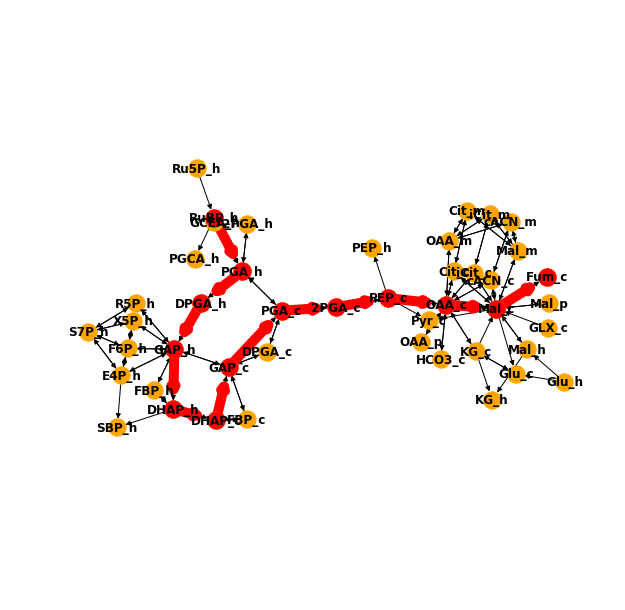

In [12]:
# Creating a subnetwork from the shortest path 
Gsub = nx.DiGraph()
Gsub.add_nodes_from(p)
# Add all reactions in which those nodes are involved in 
reacs = []
for i in p:
    metabo = model.metabolites.get_by_id(i)
    for re in metabo.reactions:
        reacs.append(re)
for r in reacs:
    prods = []
    reacs = []
    for prod in r.products:
        if "C"  in prod.formula:
            if prod.id not in rem_names:
                prods.append(prod.id)
    for s in r.reactants:
        if "C"  in s.formula:
            if s.id not in rem_names:
                reacs.append(s.id)
    if r.lower_bound == 0.0:
        # Forward Reactions
        Gsub.add_edges_from(list(itertools.product(reacs, prods)))
    if r.lower_bound < 0.0:
        # Reversible Reactions
        Gsub.add_edges_from(list(itertools.product(reacs, prods)))
        Gsub.add_edges_from(list(itertools.product(prods, reacs)))

# Drawing in the subnetwork and the shortest path      
import matplotlib.pyplot as plt
pos = nx.kamada_kawai_layout(Gsub)
plt.figure(figsize=(8,8))
plt.tight_layout
nx.draw(Gsub,pos,with_labels=True,font_weight='bold',node_color='orange')
# draw path in red
path = p
path_edges = zip(path,path[1:]) 
nx.draw_networkx_nodes(Gsub,pos,nodelist=path,node_color='r',with_labels=False)
nx.draw_networkx_edges(Gsub,pos,edgelist=path_edges,edge_color='r',width=10)
plt.axis('equal')
plt.show()

In [ ]:
reac_names = ["M_DASH_CoA_h","A_DASH_CoA_m","A_DASH_CoA_c","A_DASH_CoA_h","P_DASH_HPR_h","H_DASH_Eth_DASH_ThPP_m",
             "A_DASH_DHL_m","S_DASH_CoA_m","M_DASH_THF_m","M_DASH_ACP_h","F_DASH_THF_h","A_DASH_Glu_h",
             "A_DASH_GluP_h","H_DASH_Ser_h","PH_DASH_Ser_h","H_DASH_Cys_h","M_DASH_THF_c","5M_DASH_THF_c",
             "H_DASH_Cys_c","A_DASH_Glu_DASH_SeA_h","aH_DASH_Cys_c","PR_DASH_ATP_h","PR_DASH_AMP_h",
             "P_DASH_AICAR_DASH_P_h","Pu_DASH_AICAR_DASH_P_h","IA_DASH_P_h","Hisol_DASH_P_h","Asp_DASH_SeA_h",
             "H_DASH_Eth_DASH_ThPP_h","Glu_DASH_SeA_m","Glu_DASH_SeA_c","Glu_DASH_SeA_h","A_DASH_Orn_h",
             "PR_DASH_ANT_h","CPD_DASH_Ru5P_h","DC_DASH_AMP_h","Ind_DASH_GP_h","Arg_DASH_SCA_h","A_DASH_Ser_c",
             "A_DASH_Ser_h","SCA_DASH_SeA_m","CB_DASH_Asp_h","A_DASH_Ser_m","S_DASH_DHL_m"]
for reac in reac_names:
    metabo = model.metabolites.get_by_id(reac)
    for r in metabo.reactions:
        print(r.reaction)
        print(r.genes)

In [11]:
# Creating a metabolite to metabolite graph 
import networkx as nx
import itertools
import xlsxwriter
G = nx.DiGraph()

# Adding the nodes 
saves = []
for m in model.metabolites:
    # Adding only the carbon backbone
    if "C"  in m.formula:
        save_all = []
        save_all.append(m.id)
        save_all.append(m.name)
        if m.id not in rem_names:
            G.add_node(m.id)
            save_all.append("Yes")
        else:
            save_all.append("No")
        saves.append(save_all)
        
# Saving The Nodes To File 
workbook = xlsxwriter.Workbook('GraphMetabos.xlsx')
worksheet = workbook.add_worksheet()
worksheet.write(0, 0,"MetaboliteID")
worksheet.write(0, 1,"MetaboliteName")
worksheet.write(0, 2,"Included")
row = 1
col = 0
for i1, i2, i3 in saves:
    worksheet.write(row, col,     i1)
    worksheet.write(row, col + 1, i2)
    worksheet.write(row, col + 2, i3)
    row += 1
workbook.close()

# Adding the edges 
saves = []
for r in model.reactions:
    save_all = []
    save_all.append(r.id)
    save_all.append(str(r.reaction))
    # removing reactions which do not have an AT code breaks the model
    g = []
    for gs in r.genes:
        g.append(gs.id)
    save_all.append(str(g))
    prods = []
    reacs = []
    for p in r.products:
        if "C"  in p.formula:
            if p.id not in rem_names:
                prods.append(p.id)
    for s in r.reactants:
        if "C"  in s.formula:
            if s.id not in rem_names:
                reacs.append(s.id)
    if r.lower_bound == 0.0:
            # Forward Reactions
        G.add_edges_from(list(itertools.product(reacs, prods)))
    if r.lower_bound < 0.0:
            # Reversible Reactions
        G.add_edges_from(list(itertools.product(reacs, prods)))
        G.add_edges_from(list(itertools.product(prods, reacs)))
    saves.append(save_all)

# Graph properties
print(G.number_of_nodes())
print(G.number_of_edges())
# list(G.neighbors('Fum_c'))

# Saving The Reactions To File 
workbook = xlsxwriter.Workbook('GraphReactions.xlsx')
worksheet = workbook.add_worksheet()

worksheet.write(0, 0,"ReactionID")
worksheet.write(0, 1,"Reaction")
worksheet.write(0, 2,"AT Code")
row = 1
col = 0

for i1, i2, i3 in saves:
    worksheet.write(row, col,     i1)
    worksheet.write(row, col + 1, i2)
    worksheet.write(row, col + 2, i3)
    row += 1
workbook.close()

244
526


In [13]:
for p in nx.all_shortest_paths(G, "RuBP_h", "Suc_c"):
    print(p)
    for i in range(len(p)-1):
        s = model.metabolites.get_by_id(p[i])
        pr = model.metabolites.get_by_id(p[i+1])
        for r in model.reactions:
            if s in r.reactants and pr in r.products:
                gs = [g.id for g in r.genes]
                print(r.reaction)
                print(r.id)
                print(gs)
    print(" ")

['RuBP_h', 'PGA_h', 'DPGA_h', 'GAP_h', 'GAP_c', 'FBP_c', 'F6P_c', 'S6P_c', 'Suc_c']
CO2_h + H2O_h + RuBP_h --> 2.0 H_h + 2.0 PGA_h
RBC_h
['8*AT5G38430', 'AT5G38420', 'AT1G67090', '8*ATCG00490', 'AT5G38410']
O2_h + RuBP_h --> 2.0 H_h + PGA_h + PGCA_h
RBO_h
['8*AT5G38430', 'AT5G38410', 'AT1G67090', '8*ATCG00490', 'AT5G38420']
ATP_h + PGA_h <=> ADP_h + DPGA_h
PGAK_h
['AT3G12780', 'AT1G56190']
DPGA_h + H_h + NADPH_h --> GAP_h + NADP_h + Pi_h
GAPDH1_h
['2*AT1G42970', '2*AT3G26650', 'AT1G12900', '4*AT3G26650']
GAP_h + Pi_c <=> GAP_c + Pi_h
Tr_TPT2
['-']
DHAP_c + GAP_c <=> FBP_c
FBPA_c
['AT4G26530', 'AT2G36460', '4*AT4G26520', 'AT3G52930', 'AT5G03690']
FBP_c + H2O_c --> F6P_c + Pi_c
FBPase_c
['4*AT1G43670']
F6P_c + UDPG_c --> S6P_c + UDP_c
S6PS_c
['4*AT5G20280', '2*AT5G20280']
H2O_c + S6P_c --> Pi_c + Suc_c
S6PPh_c
['AT3G52340', '2*AT2G35840']
 
['RuBP_h', 'PGA_h', 'PGA_c', 'DPGA_c', 'GAP_c', 'FBP_c', 'F6P_c', 'S6P_c', 'Suc_c']
CO2_h + H2O_h + RuBP_h --> 2.0 H_h + 2.0 PGA_h
RBC_h
['8*AT5G3843